In [1]:
import pandas as pd
import numpy as np
import torch
import joblib
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
from pathlib import Path

from cvae import CVAE
from generate import suggest

In [2]:
TARGET_YIELD = 1200.0   # MPa
N_SAMPLES = 50
DEVICE = torch.device("cpu")

In [3]:
scalers = joblib.load("/Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 5/Projects/DDMM/RHEA-Inverse-Design-Using-VAE/data/processed/scalers.joblib")
x_scaler = scalers["x_scaler"]
y_scaler = scalers["y_scaler"]
feature_cols = scalers["feature_cols"]

In [4]:
x_dim = len(feature_cols)
y_dim = 1
model = CVAE(x_dim=x_dim, y_dim=y_dim, z_dim=4, hidden=128).to(DEVICE)
model.load_state_dict(torch.load("/Users/shrutisivakumar/Library/CloudStorage/OneDrive-Personal/College Stuff/Sem 5/Projects/DDMM/RHEA-Inverse-Design-Using-VAE/models/cvae_best.pt", map_location=DEVICE))
model.eval()

CVAE(
  (enc): Encoder(
    (net_mu): MLP(
      (net): Sequential(
        (0): Linear(in_features=10, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): GELU(approximate='none')
        (5): Linear(in_features=128, out_features=4, bias=True)
      )
    )
    (net_logvar): MLP(
      (net): Sequential(
        (0): Linear(in_features=10, out_features=128, bias=True)
        (1): GELU(approximate='none')
        (2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): GELU(approximate='none')
        (5): Linear(in_features=128, out_features=4, bias=True)
      )
    )
  )
  (dec): DecoderStrongCond(
    (fc1): Linear(in_features=5, out_features=128, bias=True)
    (fc2): Linear(in_features=129, out_features=128, bias=True)
    (fc3): Linear(in_f

In [5]:
df_gen = suggest(
    model, x_scaler, y_scaler, feature_cols,
    y_target_scalar=TARGET_YIELD, N=N_SAMPLES, refine=True
)

# Save raw suggestions
out_dir = Path("../outputs")
out_dir.mkdir(exist_ok=True)
df_gen.to_csv(out_dir / f"suggestions_y{int(TARGET_YIELD)}_raw.csv", index=False)
print(f"[INFO] Generated {len(df_gen)} candidates for target {TARGET_YIELD} MPa")

[INFO] Generated 50 candidates for target 1200.0 MPa


In [6]:
cat_cols = [
    "Equilibrium_Conditions_encoded",
    "Single_Multiphase_encoded",
    "Type_Present_Phases_encoded",
    "Tension_Compression_encoded"
]
df_gen[cat_cols] = df_gen[cat_cols].round().astype(int)

In [7]:
df_train = pd.read_csv("../data/encoded_data.csv")
X_train = df_train[feature_cols].fillna(df_train[feature_cols].median(numeric_only=True))
y_train = df_train["Yield_Strength"].fillna(df_train["Yield_Strength"].median())

In [8]:
surrogate = ExtraTreesRegressor(n_estimators=500, random_state=42)
surrogate.fit(X_train, y_train)

# Predict yield strength for generated candidates
df_gen["Predicted_Yield_Strength"] = surrogate.predict(df_gen)

# Rank by predicted yield strength
df_ranked = df_gen.sort_values(by="Predicted_Yield_Strength", ascending=False)
df_ranked.to_csv(out_dir / f"suggestions_y{int(TARGET_YIELD)}_ranked.csv", index=False)
print(f"[INFO] Ranked suggestions saved to {out_dir}/suggestions_y{int(TARGET_YIELD)}_ranked.csv")

[INFO] Ranked suggestions saved to ../outputs/suggestions_y1200_ranked.csv


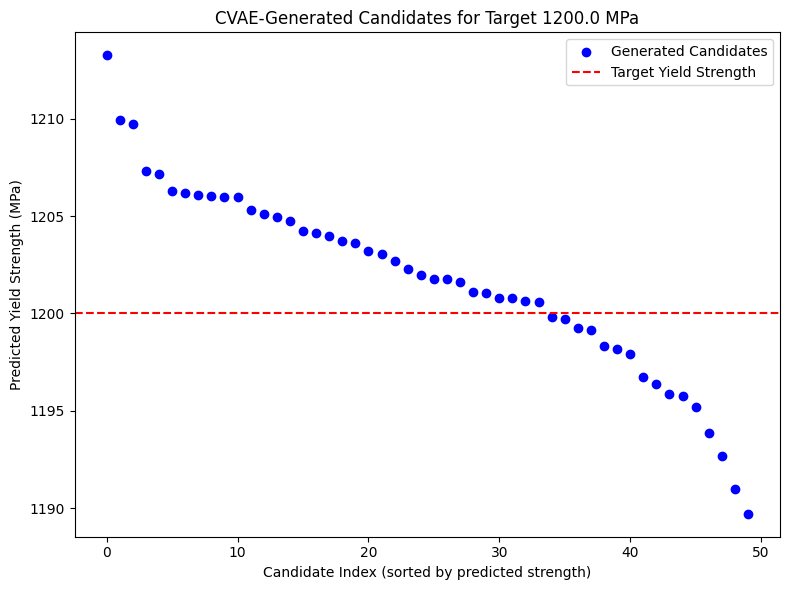

In [9]:
plt.figure(figsize=(8,6))
plt.scatter(range(len(df_ranked)), df_ranked["Predicted_Yield_Strength"], c='blue', label='Generated Candidates')
plt.axhline(y=TARGET_YIELD, color='r', linestyle='--', label='Target Yield Strength')
plt.xlabel("Candidate Index (sorted by predicted strength)")
plt.ylabel("Predicted Yield Strength (MPa)")
plt.title(f"CVAE-Generated Candidates for Target {TARGET_YIELD} MPa")
plt.legend()
plt.tight_layout()
plt.savefig(out_dir / f"yield_strength_plot_y{int(TARGET_YIELD)}.png", dpi=300)
plt.show()

In [11]:
print(df_ranked["Predicted_Yield_Strength"].describe())

count      50.000000
mean     1201.730656
std         4.838395
min      1189.710400
25%      1199.162800
50%      1201.860200
75%      1205.076900
max      1213.261200
Name: Predicted_Yield_Strength, dtype: float64
